# Bayesian Linear Regression

In [1]:
# For type annotations
from typing import Optional

# For good-looking progress bars
from tqdm.auto import tqdm, trange

# The usual NumFocus stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch as th
from torch import nn
from torch.distributions import constraints

# Pyro
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive, SVI, Trace_ELBO, MCMC, NUTS
from pyro.infer.autoguide import (
    AutoDiagonalNormal,
    AutoMultivariateNormal,
    init_to_mean,
)

Consider a prior on the weights and a likelihood of the form:
$$p(\omega) = N(0, \alpha I) \qquad p(y_i|\omega, \beta, x_i) = N(0, \omega^T\phi(x_i), \beta^{-1})$$

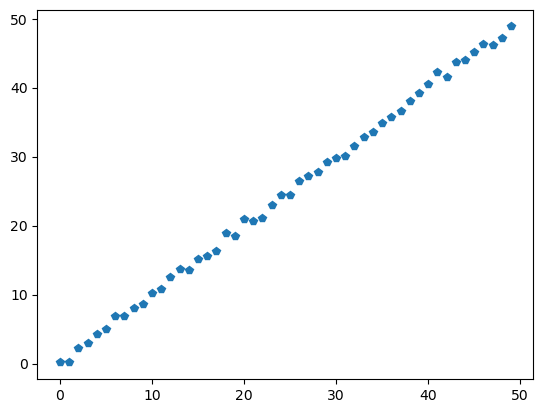

In [88]:
x = th.tensor(np.arange(0,50, 1))
y = x + dist.Normal(0, 0.5).sample([len(x)])
plt.plot(x,y, 'p')

In [89]:
alpha0: int = 1
alpha: int = 5
beta: int = 1

def Bayesian_Regression(x, y):
    bias = pyro.sample("bias", dist.Normal(0, 10))
    omega = pyro.sample("omega", dist.Normal(0, alpha))

    mean = bias + omega*x

    with pyro.plate("response", len(x)):
        response = pyro.sample("observation", dist.Normal(mean, beta), obs = y)

After defining our model, we need a way to sample from it. 
We define our No U-Turn sampler (NUTS), and use it in a MCMC sampler to obtain samples from the posterior of our model.

We can then:
- extract a summary of our model (mean, var of the parameters).
- extract the individual samples obtained by MCMC for the parameters.

In [90]:
from pyro.infer import MCMC, NUTS
SAMPLE_NUMBER = 1000
pyro.clear_param_store()
# Initialize our No U-Turn Sampler

my_kernel = NUTS(Bayesian_Regression, 
                 max_tree_depth=7) # a shallower tree helps the algorithm run faster

my_mcmc1 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)

In [91]:
my_mcmc1.run(x, y) # produces MCMC estimates for each of our coefficients, i.e. it samples from their marginal distributions.

Sample: 100%|██████████| 1100/1100 [00:17, 61.36it/s, step size=2.33e-01, acc. prob=0.952]


In [94]:
my_mcmc1.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      bias      0.07      0.27      0.07     -0.37      0.49    204.84      1.01
     omega      1.00      0.01      1.00      0.98      1.01    196.94      1.00

Number of divergences: 0


In [98]:
mcmc_samples = pd.DataFrame(my_mcmc1.get_samples())
mcmc_samples

,bias,omega
0,0.137096,0.993629
1,0.298082,0.994139
2,0.227067,0.981309
3,-0.074970,0.991056
4,0.030678,0.997347
...,...,...
995,-0.326118,1.014909
996,0.228724,0.999985
997,0.221688,0.998612
998,-0.141716,0.997325


Let us produce some plots for the posterior distributions.

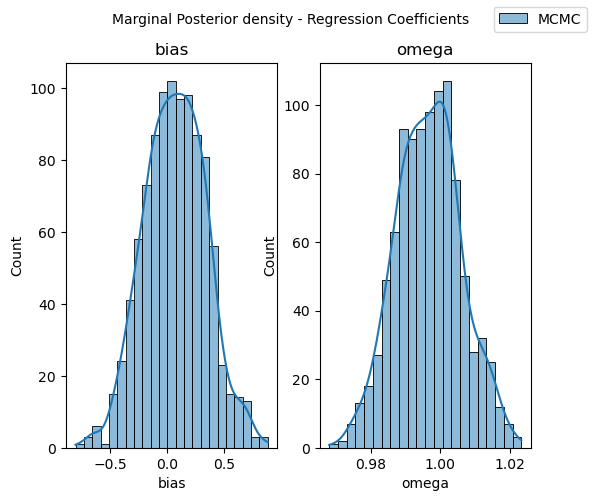

In [103]:
sites = ["bias", "omega"]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 5))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=10)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.histplot(mcmc_samples[site], ax=ax, label="MCMC", kde = True)
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')


<Axes: xlabel='bias', ylabel='omega'>

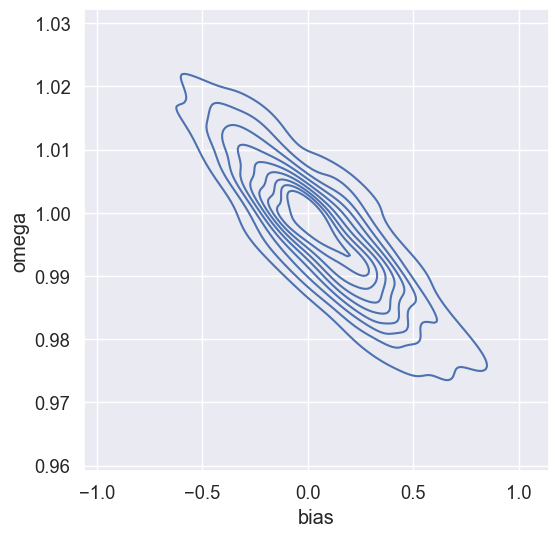

In [109]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.kdeplot(x = mcmc_samples["bias"], y = mcmc_samples["omega"], levels = 10)

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.mcmc.util import summary
from pyro.distributions import constraints
import pyro
import torch

pyro.set_rng_seed(101)

%matplotlib inline
%config InlineBackend.figure_format='retina'


### Prediction (https://pyro.ai/examples/predictive_deterministic.html)
Consider another example, where we'll also perform prediction.First of all, let us generate data using make_regression function:

Text(0.5, 0, 'x')

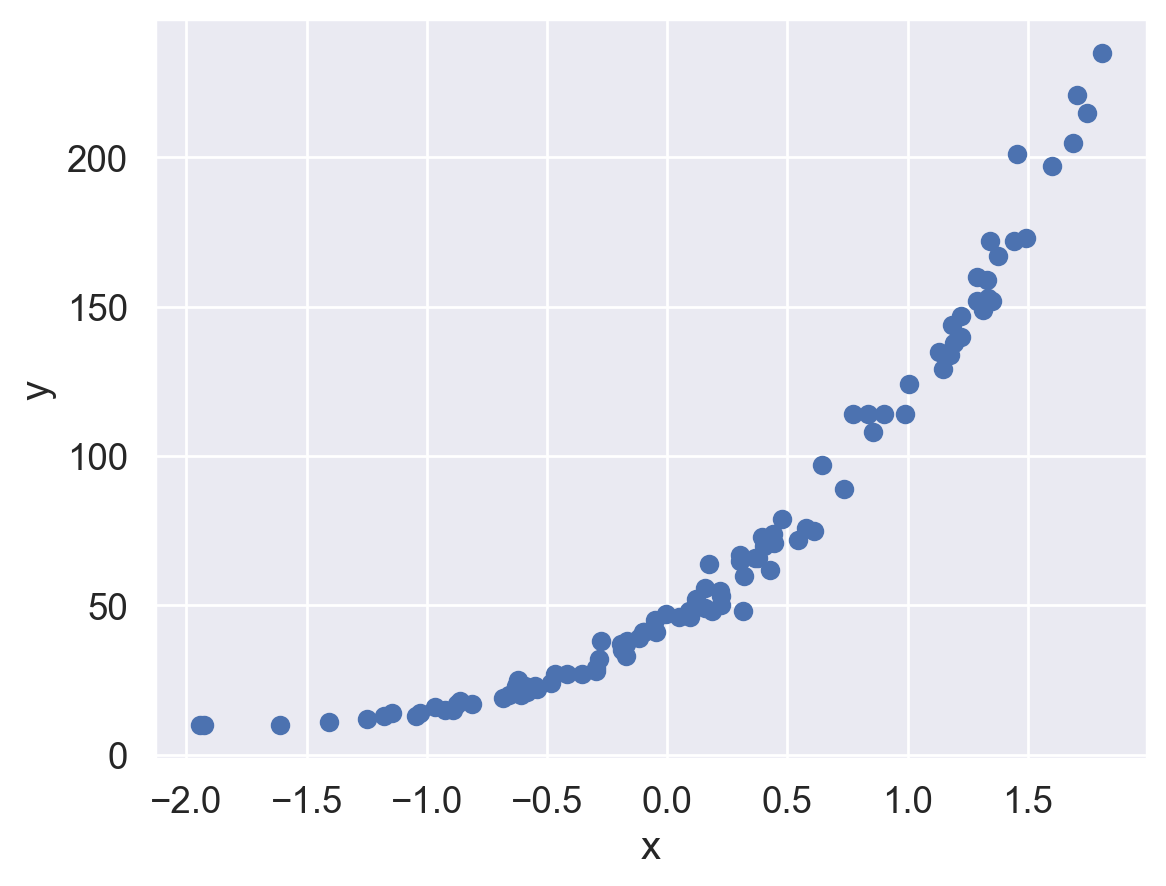

In [129]:
X, y = make_regression(n_features=1, bias=150., noise=5., random_state=108)

X_ = torch.tensor(X, dtype=torch.float)
y_ = torch.tensor((y**3)/100000. + 10., dtype=torch.float)
y_.round_().clamp_(min=0)

plt.scatter(X_, y_)
plt.ylabel('y')
plt.xlabel('x')

In [142]:
a = pyro.sample("sample", dist.Normal(0, 5).expand([2]).to_event(1))
a

tensor([ 8.0894, -1.1684])

In [143]:
a.matmul(a)

tensor(66.8031)

In [140]:
def linear_model(X, y):
    N = X.shape[0]
    p = X.shape[1]
    sigma = pyro.sample("sigma", dist.LogNormal(0, 1))
    print(type(sigma))
    bias = pyro.sample("bias", dist.Normal(0, 10))
    print(type(bias))
    weights = pyro.sample("weight", dist.Normal(0, 5).expand([p]).to_event(1)) # So that they are sampled all together accordingly
    print(type(weights))

    mean = X*weights + bias
    with pyro.plate("observations", N):
        observation = pyro.sample("observation", dist.Normal(mean, sigma), obs = y)
    return(observation)

In [141]:
linear_model(X, y)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'Tensor'

In [127]:
from pyro.infer import MCMC, NUTS
SAMPLE_NUMBER = 1000
pyro.clear_param_store()
# Initialize our No U-Turn Sampler

my_kernel = NUTS(linear_model, 
                 max_tree_depth=7) # a shallower tree helps the algorithm run faster

my_mcmc1 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)

In [128]:
my_mcmc1.run(X, y) # produces MCMC estimates for each of our coefficients, i.e. it samples from their marginal distributions.

Warmup:   0%|          | 0/1100 [00:00, ?it/s]

TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'Tensor'